In [1]:
# %%
import argparse
import random
import copy
import torch
import torchvision
import numpy as np
import pandas as pd
import sklearn.metrics as sm
import torch.nn.functional as F

In [2]:
# parse arguments
parser = argparse.ArgumentParser(description='Imbalanced MNIST Example')
parser.add_argument('--batch-size', type=int, default=64, metavar='N',
                    help='input batch size for training (default: 64)')
parser.add_argument('--test-batch-size', type=int, default=1000, metavar='N',
                    help='input batch size for testing (default: 1000)')
parser.add_argument('--seed', type=int, default=42, metavar='S',
                    help='random seed (default: 42)')
parser.add_argument('--nrow', type=int, default=5,
                    help='rows of example')
parser.add_argument('--ncol', type=int, default=10,
                    help='columns of example')
parser.add_argument('-f')


args = parser.parse_args()

torch.manual_seed(args.seed)

In [3]:
# %%
imbalanced_linear_train_dataset = torch.load('imbalanced_linear_train_dataset.pt')
imbalanced_linear_train_loader = torch.utils.data.DataLoader(imbalanced_linear_train_dataset, batch_size=args.batch_size, shuffle=True)

imbalanced_step_train_dataset = torch.load('imbalanced_step_train_dataset.pt')
imbalanced_step_train_loader = torch.utils.data.DataLoader(imbalanced_step_train_dataset, batch_size=args.batch_size, shuffle=True)

In [4]:
# %%
test_dataset = torch.load('test_dataset.pt')
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=args.test_batch_size, shuffle=True)

In [5]:
# %%
import matplotlib.pyplot as plt

import seaborn as sns


def show_mnist(arr, nrow=args.nrow, ncol=args.ncol, figsize=None):
    
    if figsize is None:
        figsize = (ncol, nrow)
        
    f, a = plt.subplots(nrow, ncol, figsize=figsize)
    
    def _do_show(the_figure, the_array):
        the_figure.imshow(the_array)
        the_figure.axis('off')
    
    for i in range(nrow):
        for j in range(ncol):
            _do_show(a[i][j], np.reshape(arr[i * ncol + j], (28, 28)))
            
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.draw()
    plt.savefig('examples.png')

In [6]:
#Getting Whole Test Dataset

X_test_dataset = []
y_test_dataset = []
for image, label in test_loader:
    for l in label:
        y_test_dataset.append(l.item())
    for i in image:
        X_test_dataset.append(i[0].reshape(1, -1).numpy()[0])

In [7]:
#Getting Whole Training Datasets

X_train_lin_dataset = []
y_train_lin_dataset = []
for image, label in imbalanced_linear_train_loader:
    for l in label:
        y_train_lin_dataset.append(l.item())
    for i in image:
        X_train_lin_dataset.append(i[0].reshape(1, -1).numpy()[0])
        
X_train_step_dataset = []
y_train_step_dataset = []
for image, label in imbalanced_step_train_loader:
    for l in label:
        y_train_step_dataset.append(l.item())
    for i in image:
        X_train_step_dataset.append(i[0].reshape(1, -1).numpy()[0])

In [8]:
#Logistic Regression

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, make_scorer
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.preprocessing import label_binarize

#X_test_dataset = next(iter(test_loader))[0].numpy()
#X_test_dataset = X_test_dataset.reshape((X_test_dataset.shape[0], -1))
#y_test_dataset = next(iter(test_loader))[1].numpy()

for i in range(len(y_test_dataset)):
    if y_test_dataset[i] == 0:
        y_test_dataset[i] = 0
    else:
        y_test_dataset[i] = 1

#X_train_lin_dataset = next(iter(imbalanced_linear_train_loader))[0].numpy()
#X_train_lin_dataset = X_train_lin_dataset.reshape((X_train_lin_dataset.shape[0], -1))
#y_train_lin_dataset = next(iter(imbalanced_linear_train_loader))[1].numpy()

#X_train_step_dataset = next(iter(imbalanced_step_train_loader))[0].numpy()
#X_train_step_dataset = X_train_step_dataset.reshape((X_train_step_dataset.shape[0], -1))
#y_train_step_dataset = next(iter(imbalanced_step_train_loader))[1].numpy()

In [9]:
#Linear

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import pandas as pd

X_lin = X_train_lin_dataset
y_lin = y_train_lin_dataset

for i in range(len(y_lin)):
    if y_lin[i] == 0:
        y_lin[i] = 0
    else:
        y_lin[i] = 1
        
X_lin = pd.DataFrame(X_lin)
y_lin = pd.DataFrame(y_lin)

num_of_folds = 10
max_iter = 1e8

auc_dict = {'log_reg': 0}
chosen_hyperparam_dict = {}

skf=StratifiedKFold(n_splits=num_of_folds, shuffle=True)
for train_index, test_index in skf.split(X_lin, y_lin):
    X_train, X_test = X_lin.iloc[train_index], X_lin.iloc[test_index]
    y_train, y_test = y_lin.iloc[train_index].values.ravel(), y_lin.iloc[test_index].values.ravel()

    log_regressor = LogisticRegression(penalty='l2', max_iter = max_iter)
    log_regressor.fit(X_train, y_train)
    
    log_pred = log_regressor.predict(X_test)
    
    auc_dict['log_reg'] += roc_auc_score(y_test, log_pred)/num_of_folds

In [10]:
lin_scaler = StandardScaler()
lin_scaler.fit(X_train_lin_dataset)
X_train_lin_dataset = lin_scaler.transform(X_train_lin_dataset)
X_test_lin_dataset = lin_scaler.transform(X_test_dataset)

lin_model = LogisticRegression(C = 0.01, max_iter = 1e8, solver = 'lbfgs')
lin_model.fit(X_train_lin_dataset, y_train_lin_dataset)

y_lin_pred = lin_model.predict_proba(X_test_dataset)[:,1]

lin_AUROC = roc_auc_score(y_true = y_test_dataset, y_score = y_lin_pred, multi_class = 'ovr')
print("Linear AUROC: " + repr(lin_AUROC))

Linear AUROC: 0.9980716322005521


In [11]:
#Step

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import pandas as pd

X_step = X_train_step_dataset
y_step = y_train_step_dataset

for i in range(len(y_step)):
    if y_step[i] == 0:
        y_step[i] = 0
    else:
        y_step[i] = 1
        
X_step = pd.DataFrame(X_step)
y_step = pd.DataFrame(y_step)

num_of_folds = 10
max_iter = 1e8

auc_dict = {'log_reg': 0}
chosen_hyperparam_dict = {}

skf=StratifiedKFold(n_splits=num_of_folds, shuffle=True)
for train_index, test_index in skf.split(X_step, y_step):
    X_train, X_test = X_step.iloc[train_index], X_step.iloc[test_index]
    y_train, y_test = y_step.iloc[train_index].values.ravel(), y_step.iloc[test_index].values.ravel()

    log_regressor = LogisticRegression(penalty='l2', max_iter = max_iter)
    log_regressor.fit(X_train, y_train)
    
    log_pred = log_regressor.predict(X_test)
    
    auc_dict['log_reg'] += roc_auc_score(y_test, log_pred)/num_of_folds

In [12]:
step_scaler = StandardScaler()
step_scaler.fit(X_train_step_dataset)
X_train_step_dataset = step_scaler.transform(X_train_step_dataset)
X_test_step_dataset = step_scaler.transform(X_test_dataset)

step_model = LogisticRegression(C = 0.01, max_iter = 1e8, solver = 'lbfgs')
step_model.fit(X_train_step_dataset, y_train_step_dataset)

y_step_pred = step_model.predict_proba(X_test_dataset)[:,1]

step_AUROC = roc_auc_score(y_true = y_test_dataset, y_score = y_step_pred, multi_class = 'ovr')
print("Step AUROC: " + repr(step_AUROC))

Step AUROC: 0.9980574912891986


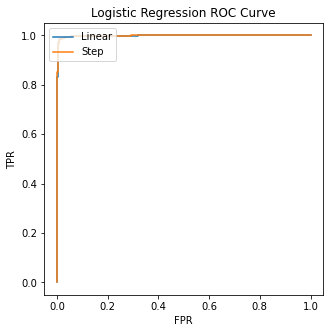

In [13]:
y_lin_score = lin_model.predict_proba(X_test_dataset)[:,1]
y_step_score = step_model.predict_proba(X_test_dataset)[:,1]

fpr1, tpr1, th1 = roc_curve(y_test_dataset, y_lin_score)
fpr2, tpr2, th2 = roc_curve(y_test_dataset, y_step_score)

plt.subplots(figsize=(5, 5))
plt.title('Logistic Regression ROC Curve')
plt.plot(fpr1, tpr1, label = "Linear")
plt.plot(fpr2, tpr2, label = "Step")
plt.legend(loc="upper left")
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.savefig('logreg_linear_step_roc_curve.png')
plt.show()

In [14]:
from joblib import dump, load

dump(lin_model, 'logreg_linear.joblib')
dump(step_model, 'logreg_step.joblib')

['logreg_step.joblib']

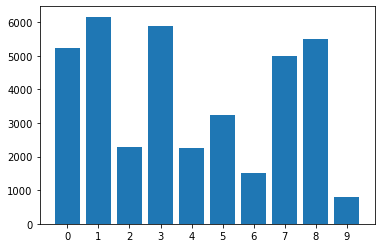

In [15]:
#print('Distribution of classes in linear imbalanced dataset:')
fig, ax = plt.subplots()
_, counts = np.unique(imbalanced_linear_train_loader.dataset.train_labels, return_counts=True)
num_classes = 10
classe_labels = range(num_classes)
ax.bar(classe_labels, counts)
ax.set_xticks(classe_labels)
plt.savefig('dist linear.png')
plt.show()

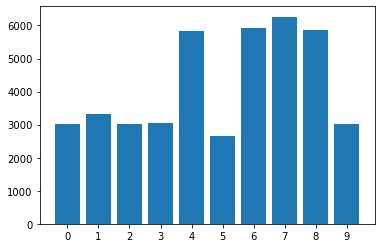

In [16]:
#print('Distribution of classes in step imbalanced dataset:')
fig, ax = plt.subplots()
_, counts = np.unique(imbalanced_step_train_loader.dataset.train_labels, return_counts=True)
num_classes = 10
classe_labels = range(num_classes)
ax.bar(classe_labels, counts)
ax.set_xticks(classe_labels)
plt.savefig('dist step.png')
plt.show()

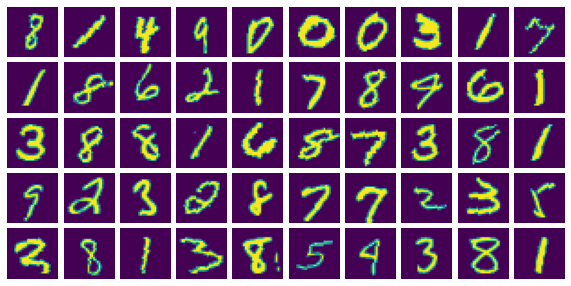

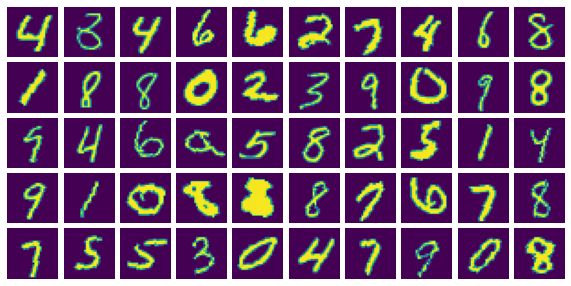

In [17]:
# %%
for data, _ in imbalanced_linear_train_loader:
    show_mnist(data)
    break
    
for data, _ in imbalanced_step_train_loader:
    show_mnist(data)
    break